# Google Colab (Skip locally)

In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6135/HW3_2025/src" #@param {type:"string"}
!ln -Ts "$folder" /content/src 2> /dev/null

# Add the assignment folder to Python path
if '/content/src' not in sys.path:
  sys.path.insert(0, '/content/src')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

# Imports & Setup

In [2]:
%matplotlib inline
import warnings
from shutil import make_archive
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
import random

from q1_train_vae import experiment1
from q1_plots_vae import generate_images, plot_loss, plot_traversals, generate_latent_traversals, plot_interpolation_comparison
from q2_trainer_ddpm import experiment2
from q3_trainer_cfg import experiment3

models = ['VAE', 'DDPM', 'CFG']

# Experiments

## Experiment 1 (VAE)

In [30]:
vae_model, vae_optimizer = experiment1(False)
dataset = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())

Loaded checkpoint from epoch 20


Saved loss plot to results/experiment1/loss_curve.png


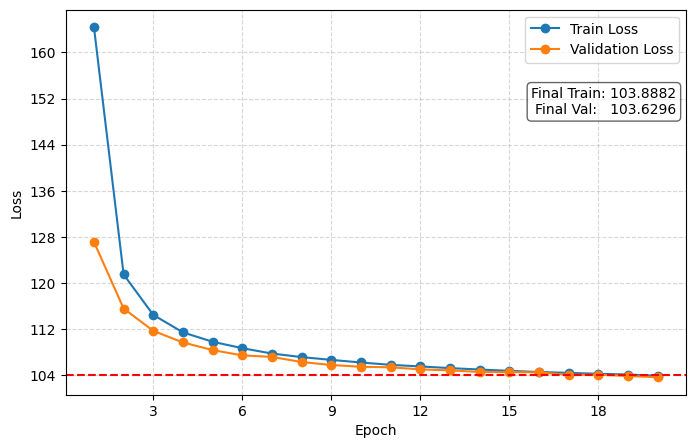

In [4]:
plot_loss('results/experiment1/history.json', save_path='results/experiment1/loss_curve.png', show=True)

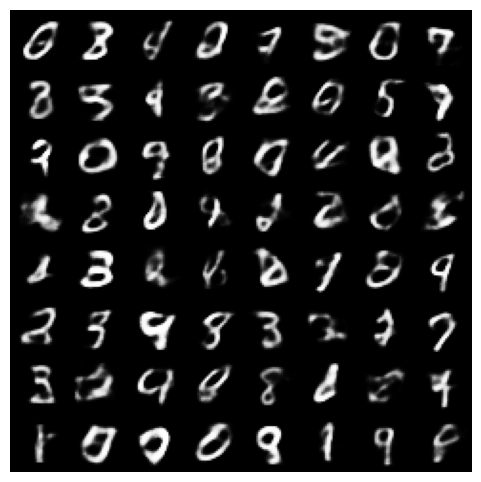

In [4]:
vae_samples = generate_images(vae_model, num_images=64, show=True, file_path='results/experiment1/vae_samples.png')

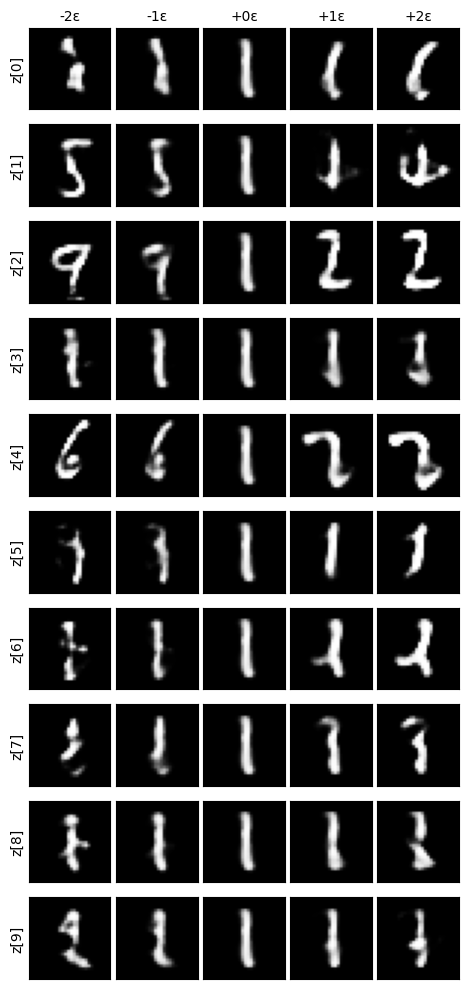

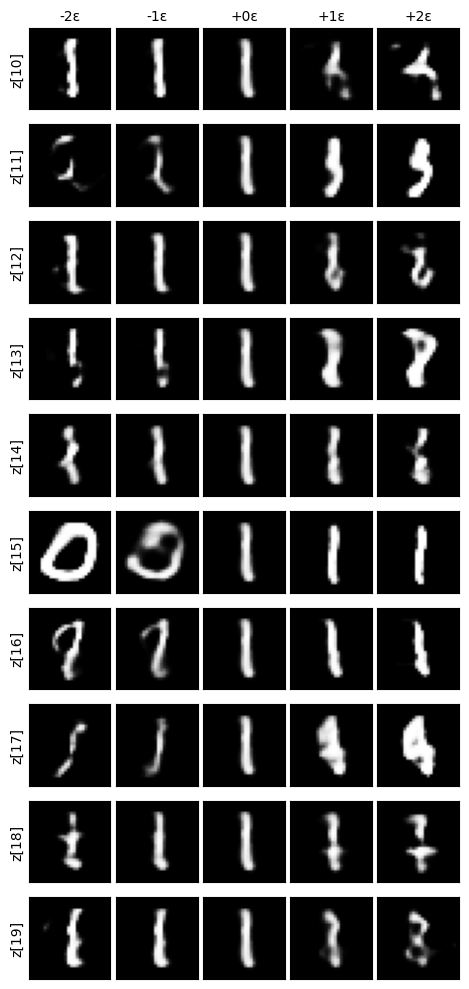

In [ ]:
rand_idx = random.randint(0, len(dataset) - 1)
datapoint, _ = dataset[rand_idx]

eps = 4.0
tr_dp = generate_latent_traversals(vae_model, n_factors=20, n_steps=5, eps=eps, data_sample=datapoint)
plot_traversals(tr_dp, eps=eps, save_path='results/experiment1/traversals_dp.png', show=True)

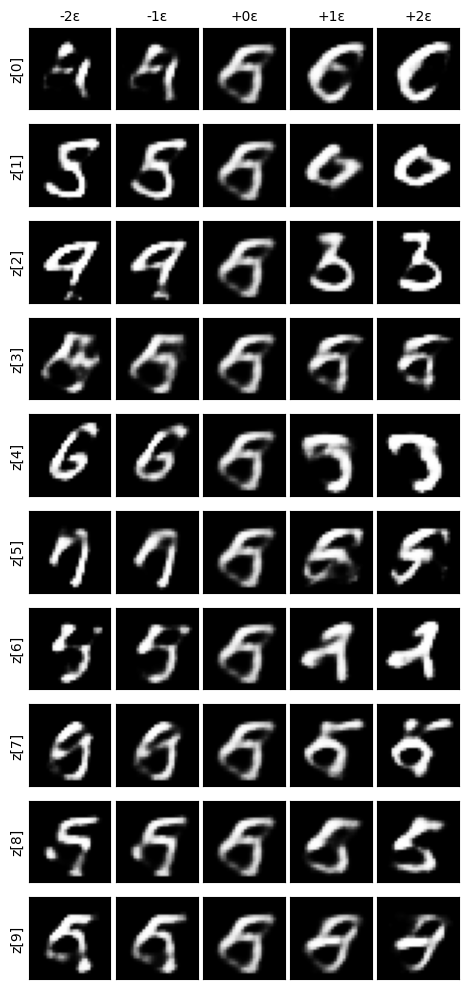

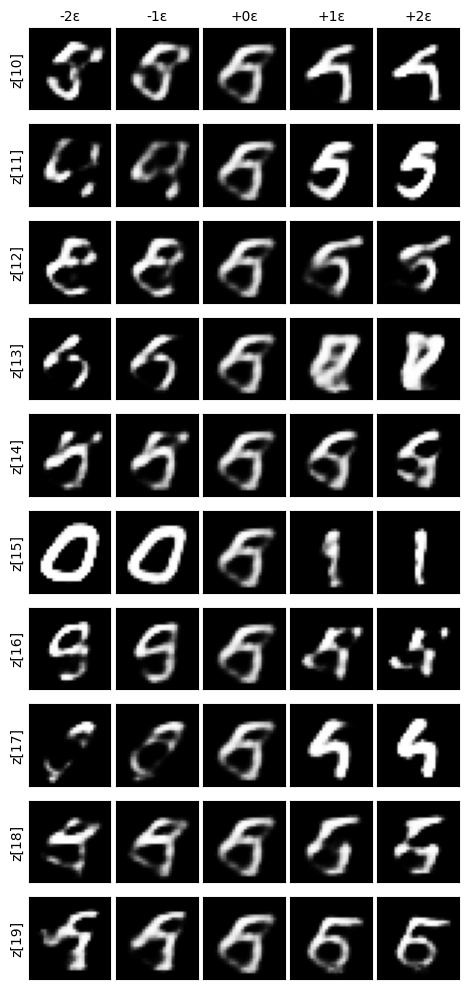

In [5]:
tr_gs = generate_latent_traversals(vae_model, n_factors=20, n_steps=5, eps=eps)
plot_traversals(tr_gs, eps=eps, save_path='results/experiment1/traversals_gs.png', show=True)

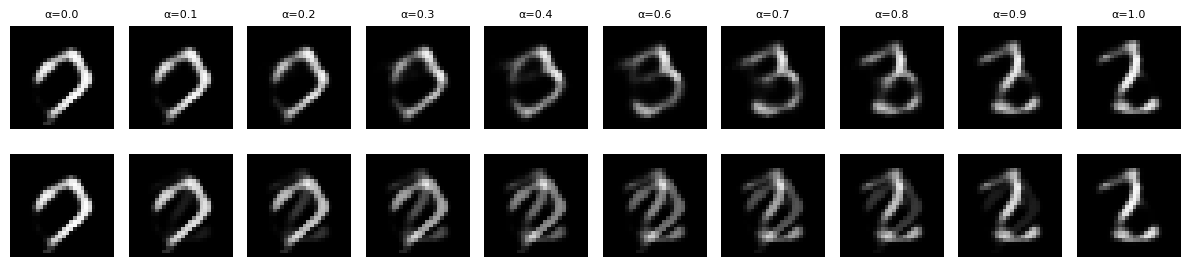

In [34]:
plot_interpolation_comparison(vae_model, num_steps=10, save_path='results/experiment1/interpolation_gs.png', show=True)

Interpolating between 2 and 8


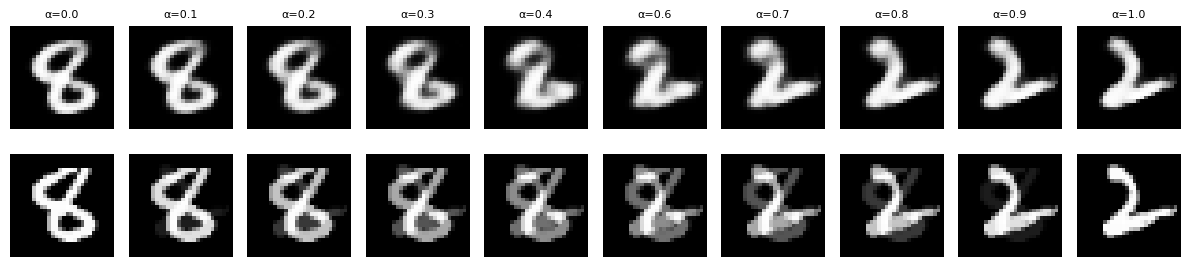

In [51]:
idx1 = random.randint(0, len(dataset) - 1)
x1, y1 = dataset[idx1]
idx2 = random.randint(0, len(dataset) - 1)
x2, y2 = dataset[idx2]
print(f"Interpolating between {y1} and {y2}")
plot_interpolation_comparison(
    vae_model,
    endpoints=(x1.unsqueeze(0),x2.unsqueeze(0)), 
    num_steps=10,
    save_path='results/experiment1/interpolation_ds.png',
    show=True)

In [ ]:
# TODO make_archive('experiment1', 'zip', 'results/experiment1')

## Experiment 2 (DDPM)

In [ ]:
ddpm_trainer = experiment2(False)

In [ ]:
n_samples = 9
n_steps = 1000
ddpm_samples = ddpm_trainer.sample(n_steps=n_steps, n_samples=n_samples, show=True, save=True)

In [ ]:
grid = torchvision.utils.make_grid(ddpm_samples, nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')
plt.show()

No weights to load
[Checkpoint] Loaded model at epoch 5 from results/experiment2\checkpoints\ddpm_epoch_005.pt
No weights to load
[Checkpoint] Loaded model at epoch 9 from results/experiment2\checkpoints\ddpm_epoch_009.pt
No weights to load
[Checkpoint] Loaded model at epoch 15 from results/experiment2\checkpoints\ddpm_epoch_015.pt
No weights to load
[Checkpoint] Loaded model at epoch 19 from results/experiment2\checkpoints\ddpm_epoch_019.pt


Sampling: 200it [00:17, 11.53it/s]


Showing/saving samples from epoch 5


Sampling: 200it [00:19, 10.52it/s]


Showing/saving samples from epoch 9


Sampling: 200it [00:19, 10.30it/s]


Showing/saving samples from epoch 15


Sampling: 200it [00:20,  9.55it/s]


Showing/saving samples from epoch 19


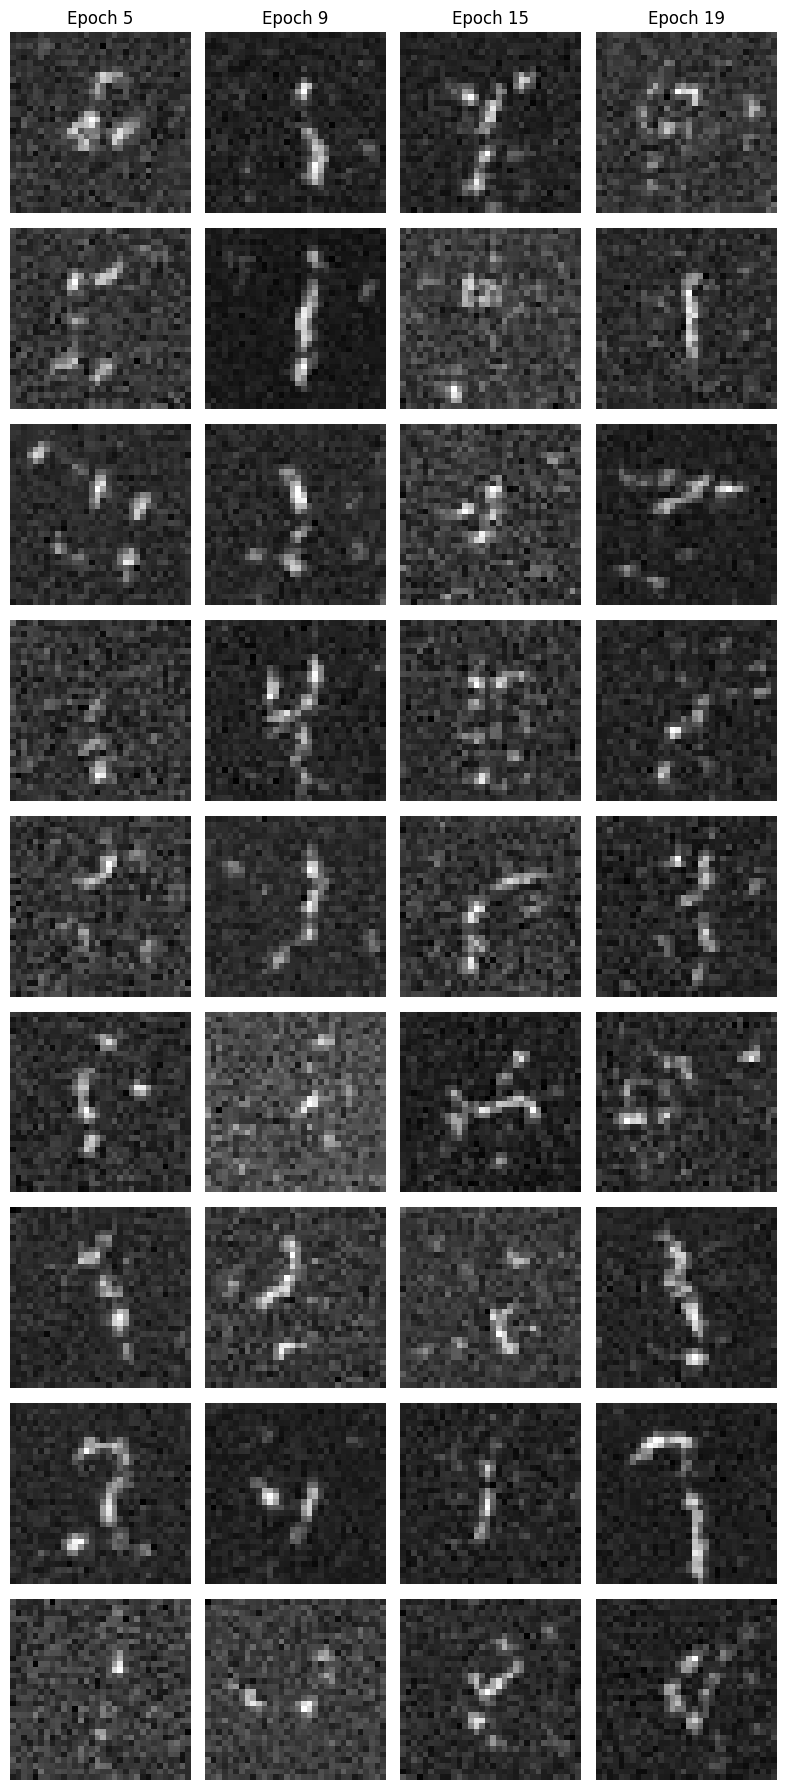

In [55]:
from q2_plots_ddpm import plot_samples_across_epochs

# plot 8 samples each at epochs 5, 10, 15, 20:
plot_samples_across_epochs(
    epochs=[5, 9, 15, 19],
    n_samples=9,
    seed=42,
    n_steps=100
)

In [ ]:
# TODO make_archive('experiment2', 'zip', 'results/experiment2')

## Experiment 3 (CFG)

In [57]:
cfg_trainer = experiment3(False)

[Checkpoint] Loaded model at epoch 19 from results/experiment3\checkpoints\cfg_epoch_019.pt


In [ ]:
n_samples = 3
labels = torch.randint(0, 9, (n_samples,), device=cfg_trainer.args.device)
n_steps = 1000
cfg_samples = cfg_trainer.sample(n_steps=n_steps, show=True, save=True)

In [ ]:
grid = torchvision.utils.make_grid(cfg_samples, nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from q3_trainer_cfg import experiment3

def plot_evolution_across_epochs(
    epochs=[5, 10, 15, 20],
    n_steps=None,
    labels: torch.Tensor = None,
    seed=42,
):
    """
    Samples the CFG diffusion model at specific epochs and plots the results.

    Columns → epochs; Rows → fixed labels.

    Args:
        epochs   (list[int]): which checkpoint epochs to load & sample.
        n_steps   (int|None): number of reverse diffusion steps to use.
                             If None, uses trainer.args.n_steps.
        labels    (torch.Tensor|None): tensor of shape (n_samples,) with labels [0–9].
                             If None, will sample uniformly at random once,
                             using trainer.args.n_samples as length.
        seed      (int): RNG seed for reproducibility of labels and sampling.
    """
    # 1) Fix RNG
    torch.manual_seed(seed)

    # 2) Grab device & default sample count
    tmp_trainer = experiment3(train=False, checkpoint_epoch=epochs[0])
    device = tmp_trainer.args.device
    default_n = tmp_trainer.args.n_samples

    # 3) Prepare labels
    if labels is None:
        n = default_n
        labels = torch.randint(0, 10, (n,), device=device)
    else:
        labels = labels.to(device)
        n = labels.numel()
        assert labels.dim() == 1, "labels must be a 1-D tensor"
    
    all_samples = []
    for ep in epochs:
        # load model at epoch `ep`
        trainer = experiment3(train=False, checkpoint_epoch=ep)
        trainer.args.n_samples = n

        # sample
        z_t = trainer.sample(
            labels=labels,
            n_steps=n_steps,
            set_seed=True,
            show=False,
            save=False,
        )
        all_samples.append(z_t)

    # 4) Plot: rows = samples/labels, cols = epochs
    fig, axes = plt.subplots(
        n, len(epochs),
        figsize=(len(epochs)*3, n*3),
        squeeze=False
    )
    for col, z_t in enumerate(all_samples):
        for row in range(n):
            ax = axes[row][col]
            img = z_t[row].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            # hide ticks & spines (but not the ylabel)
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

            if row == 0:
                ax.set_title(f'Epoch {epochs[col]}')
            if col == 0:
                ax.set_ylabel(f'Label {labels[row].item()}',
                            rotation=90, fontsize=12)
    plt.tight_layout()
    plt.show()


[Checkpoint] Loaded model at epoch 5 from results/experiment3\checkpoints\cfg_epoch_005.pt
[Checkpoint] Loaded model at epoch 5 from results/experiment3\checkpoints\cfg_epoch_005.pt


100it [00:06, 15.42it/s]


Showing/saving samples from epoch 5 with labels: [7, 6, 8, 8, 2, 8, 0, 0, 6]
[Checkpoint] Loaded model at epoch 9 from results/experiment3\checkpoints\cfg_epoch_009.pt


100it [00:06, 15.01it/s]


Showing/saving samples from epoch 9 with labels: [7, 6, 8, 8, 2, 8, 0, 0, 6]
[Checkpoint] Loaded model at epoch 15 from results/experiment3\checkpoints\cfg_epoch_015.pt


100it [00:07, 13.26it/s]


Showing/saving samples from epoch 15 with labels: [7, 6, 8, 8, 2, 8, 0, 0, 6]
[Checkpoint] Loaded model at epoch 19 from results/experiment3\checkpoints\cfg_epoch_019.pt


100it [00:08, 11.75it/s]


Showing/saving samples from epoch 19 with labels: [7, 6, 8, 8, 2, 8, 0, 0, 6]


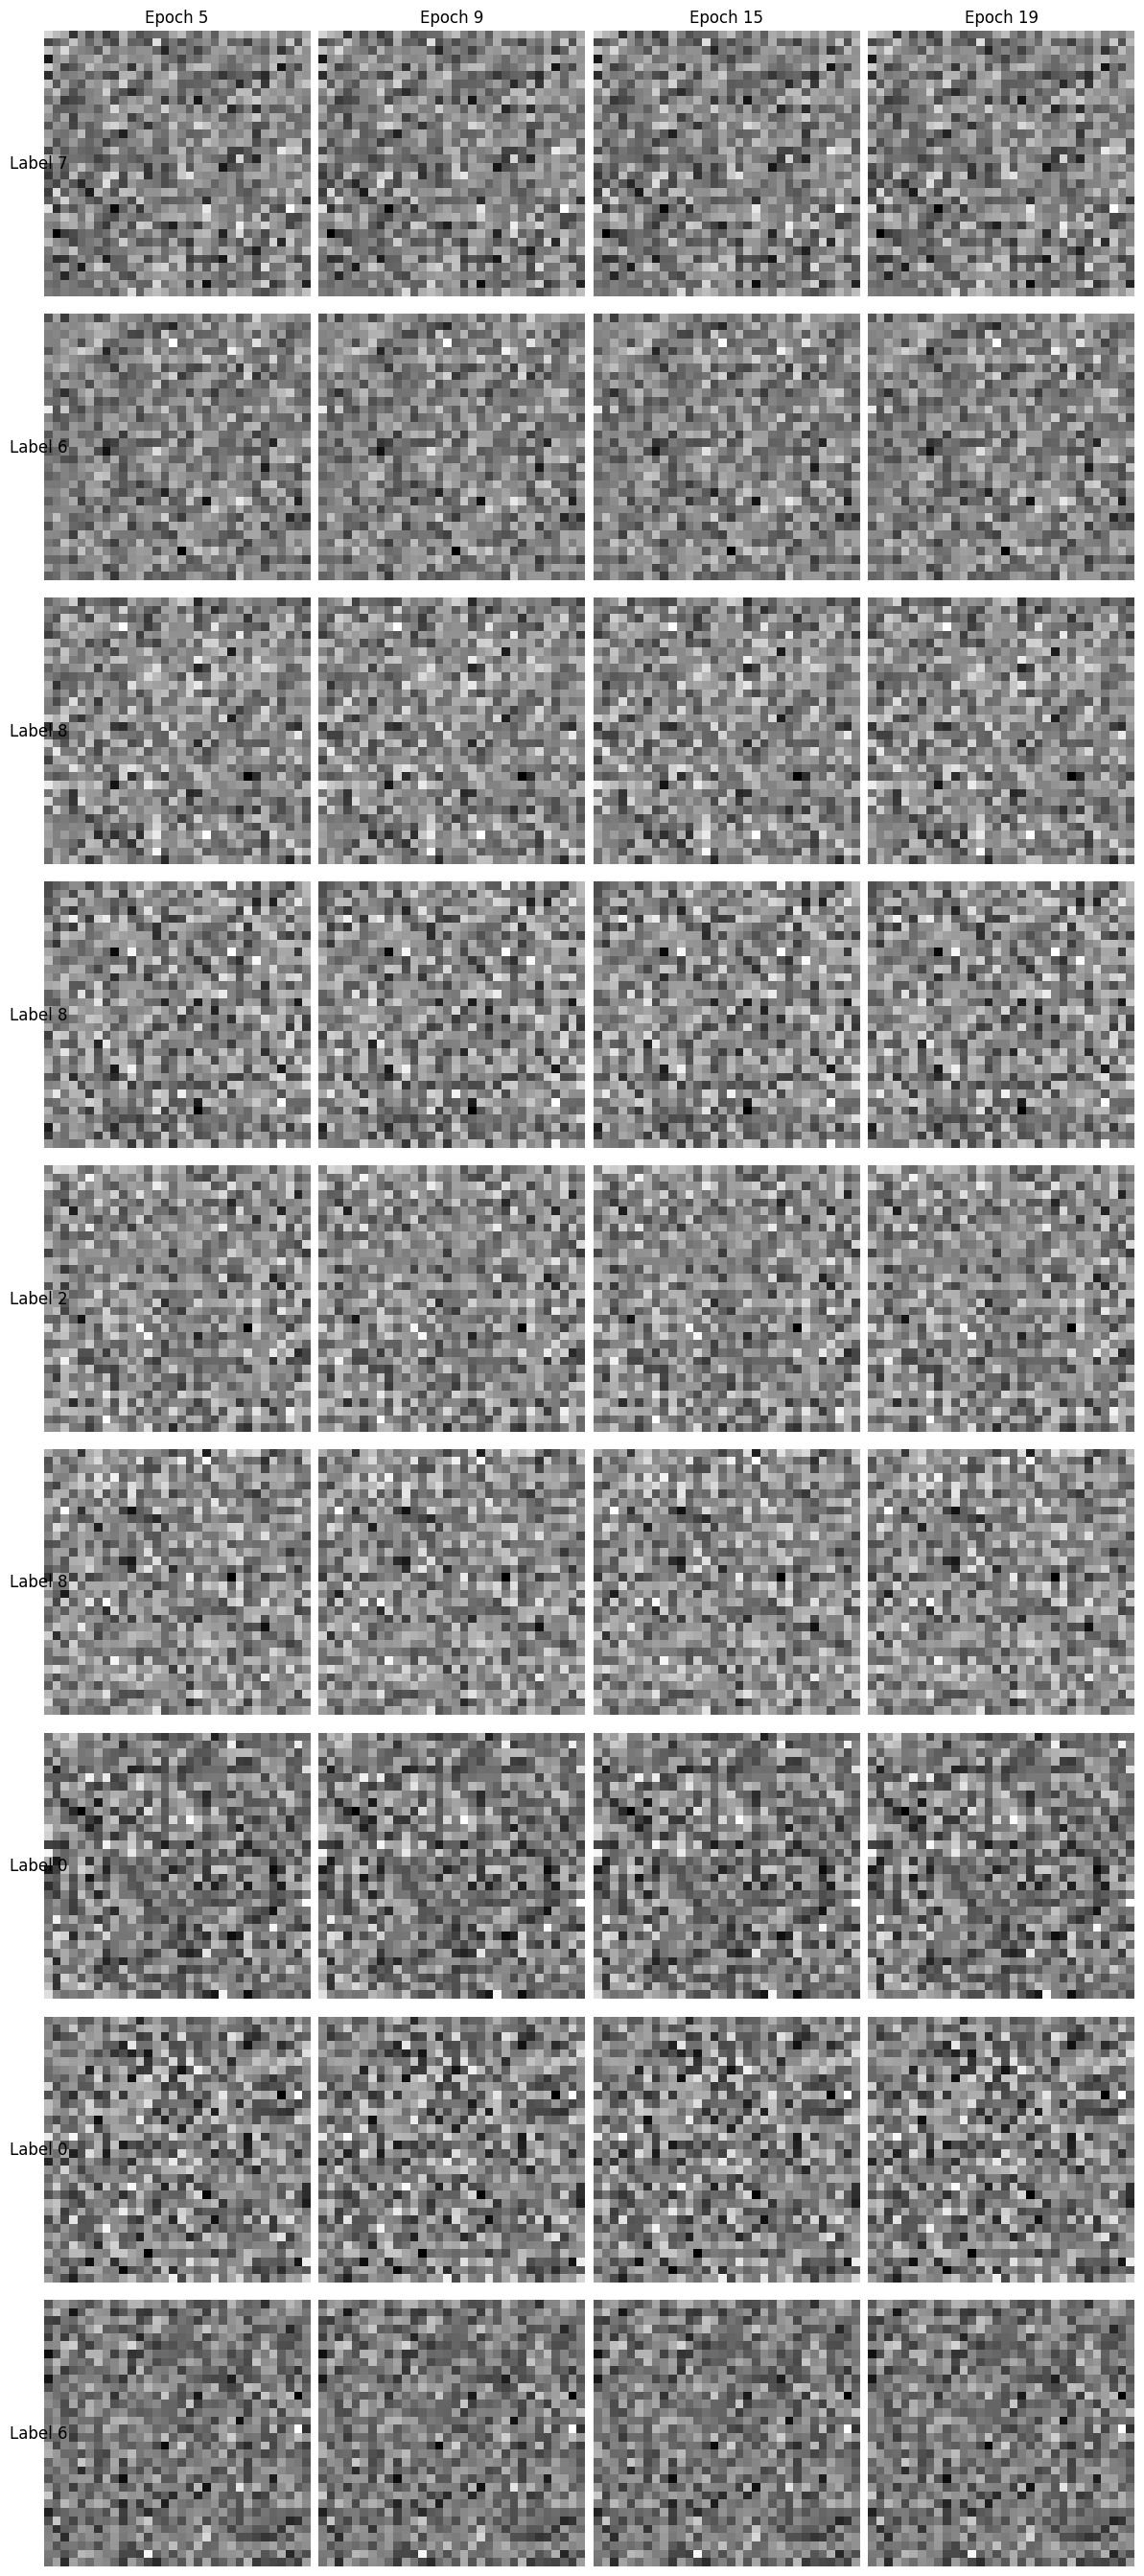

In [67]:

n_samples = 9
labels = torch.randint(0, 9, (n_samples,), device=cfg_trainer.args.device)
plot_evolution_across_epochs(
    epochs=[5, 9, 15, 19],
    n_steps=100,
    labels=labels,
)


In [ ]:
# TODO make_archive('experiment3', 'zip', 'results/experiment3')